In [1]:
import os
import pandas as pd
import nltk
from collections import Counter

ROOTDIR = os.path.abspath(os.path.abspath(os.path.join(os.getcwd(), "..")))
DATADIR = os.path.join(ROOTDIR, 'data')
MODELDIR = os.path.join(ROOTDIR, 'model')

In [2]:
df = pd.read_csv(os.path.join(DATADIR, 'question.csv'), nrows=100000)
texts = df.content

texts

#把句子变成词

0       Given an array of integers, return indices of ...
1       You are given two non-empty linked lists repre...
2       Given a string, find the length of the longest...
3       There are two sorted arrays nums1 and nums2 of...
4       Given a string s, find the longest palindromic...
                              ...                        
1152    Given an array points containing the coordinat...
1153    Given an array of numbers arr. A sequence of n...
1154    We have a wooden plank of the length n units. ...
1155    Given a rows * columns matrix mat of ones and ...
1156    Given a string num representing the digits of ...
Name: content, Length: 1157, dtype: object

In [3]:
tokenized = [nltk.word_tokenize(question) for question in texts]

n = 10 #arbitrary pick
print('Example question:\n   Raw: {} \n\n   Tokenized: {}'.format(texts[n], [i for i in tokenized[n]]))

Example question:
   Raw: Given n non-negative integers a1, a2, ..., an , where each represents a point at coordinate (i, ai). n vertical lines are drawn such that the two endpoints of line i is at (i, ai) and (i, 0). Find two lines, which together with x-axis forms a container, such that the container contains the most water.

Note: You may not slant the container and n is at least 2.

 



The above vertical lines are represented by array [1,8,6,2,5,4,8,3,7]. In this case, the max area of water (blue section) the container can contain is 49. 

 

Example:


Input: [1,8,6,2,5,4,8,3,7]
Output: 49 

   Tokenized: ['Given', 'n', 'non-negative', 'integers', 'a1', ',', 'a2', ',', '...', ',', 'an', ',', 'where', 'each', 'represents', 'a', 'point', 'at', 'coordinate', '(', 'i', ',', 'ai', ')', '.', 'n', 'vertical', 'lines', 'are', 'drawn', 'such', 'that', 'the', 'two', 'endpoints', 'of', 'line', 'i', 'is', 'at', '(', 'i', ',', 'ai', ')', 'and', '(', 'i', ',', '0', ')', '.', 'Find', 'two', 'l

In [4]:
#Note that we convert all tokens to lower case, otherwise words like *The* and *the* are different tokens.
token_counter = Counter(token.lower() for sentence in tokenized for token in sentence)
top10 = token_counter.most_common()[:10]
for i, t in enumerate(top10):
    print('{:>2}.{:>5}  freq: {:>7}'.format(i+1, t[0], t[1]))

 1.    ,  freq:   15039
 2.    :  freq:   11086
 3.  the  freq:    9186
 4.    [  freq:    8519
 5.    ]  freq:    8501
 6.    .  freq:    8350
 7.    =  freq:    6760
 8.   ''  freq:    6620
 9.    1  freq:    4711
10.    a  freq:    4201


In [5]:
#删除字典中只出现一次的词
from gensim import corpora

# Create a dictionary from list of documents in order to create BOW model
dictionary = corpora.Dictionary(tokenized)
print ('before:\t',len(dictionary))
only_once_key=[]
for key in dictionary.iterkeys():
    if dictionary.dfs[key]==1:
        only_once_key.append(key)
dictionary.filter_tokens(bad_ids=only_once_key)
print ('after:\t',len(dictionary))

dictionary.save(MODELDIR + '/question.dict')

before:	 9481
after:	 3484


In [6]:
#删除字典中只出现一次的词
frequent_tokenized = []
for sentence in tokenized:
    ind_list = dictionary.doc2idx(sentence)
    words = []
    for i,ind in enumerate(ind_list):
        if ind != -1:
            words.append(sentence[i])
    frequent_tokenized.append(words)

In [7]:
print('raw:\t',sum([len(i) for i in tokenized]))
print('freq:\t',sum([len(i) for i in frequent_tokenized]))

raw:	 250010
freq:	 239256


In [8]:
#删除形容词和标点符号
from nltk.corpus import stopwords
from string import punctuation
from itertools import chain
from tqdm import tqdm

def clean_text(tokenized_list, sw, punct):
    new_list = []
    for doc in tqdm(tokenized_list):
        new_list.append([token.lower() for token in doc if token.lower() not in chain(punct, sw)])
    return new_list

# Remove punctuations and stopwords, and lower-case text
sw = stopwords.words('english')
punct = ' \n'+'!"#%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
cleaned = clean_text(frequent_tokenized, sw, punct)

100%|████████████████████████████████████████████████████████████████████████████| 1157/1157 [00:00<00:00, 2192.96it/s]


In [9]:
#整合其他来源文本
from nltk.corpus import gutenberg
from nltk.corpus import webtext
from nltk.corpus import brown

cleaned_gutenberg = clean_text(gutenberg.sents(), [], punct)
cleaned_webtext = clean_text(webtext.sents(), [], punct)
cleaned_brown = clean_text(brown.sents(), [], punct)

all_text_data = cleaned +  cleaned_gutenberg + cleaned_webtext + cleaned_brown

100%|█████████████████████████████████████████████████████████████████████████| 57340/57340 [00:02<00:00, 20869.85it/s]


In [10]:
#单词转化向量（浮点数）（训练）
from gensim import models

w2v_model = models.Word2Vec(all_text_data,
                        size = 300,
                        window = 5,
                        min_count = 1,
                        sg = 0,
                        alpha = 0.025,
                        iter=10,
                        batch_words = 10000)

In [11]:
w2v_model.save(MODELDIR + "/word2vec.model")

In [12]:
#离搜索词最近的词极其向量
w2v_model.wv.most_similar(positive=['computer'])

[('certificate', 0.8047553300857544),
 ('ms', 0.7994484305381775),
 ('server', 0.7980078458786011),
 ('banking', 0.7971575856208801),
 ('ssl', 0.7907871007919312),
 ('zip', 0.7845491766929626),
 ('launches', 0.7805339097976685),
 ('user', 0.7802754640579224),
 ('helper', 0.7794123888015747),
 ('downloading', 0.777411162853241)]

In [13]:
w2v_model.wv.most_similar(positive=['she','her','hers','herself'], negative=['he','him','his','himself'])

[('unaltered', 0.44433915615081787),
 ('effecte', 0.44216883182525635),
 ('miss', 0.42859601974487305),
 ('costliness', 0.42665207386016846),
 ('vnmaske', 0.4260025918483734),
 ('cherisheth', 0.420838862657547),
 ('rechurned', 0.4148135781288147),
 ('grandam', 0.41218680143356323),
 ('oilman-rancher', 0.4106166362762451),
 ('sweet-throated', 0.40882742404937744)]

In [14]:
#向量相似词绘图
from sklearn.metrics import pairwise

f_tokens = [token for token,weight in w2v_model.wv.most_similar(positive=['food'], topn=50)]
vectors = [w2v_model.wv[word] for word in f_tokens]
dist_matrix = pairwise.pairwise_distances(vectors, metric='cosine')

In [15]:
#降维
from sklearn.manifold import MDS
mds = MDS(n_components = 2, dissimilarity='precomputed')
embeddings = mds.fit_transform(dist_matrix)

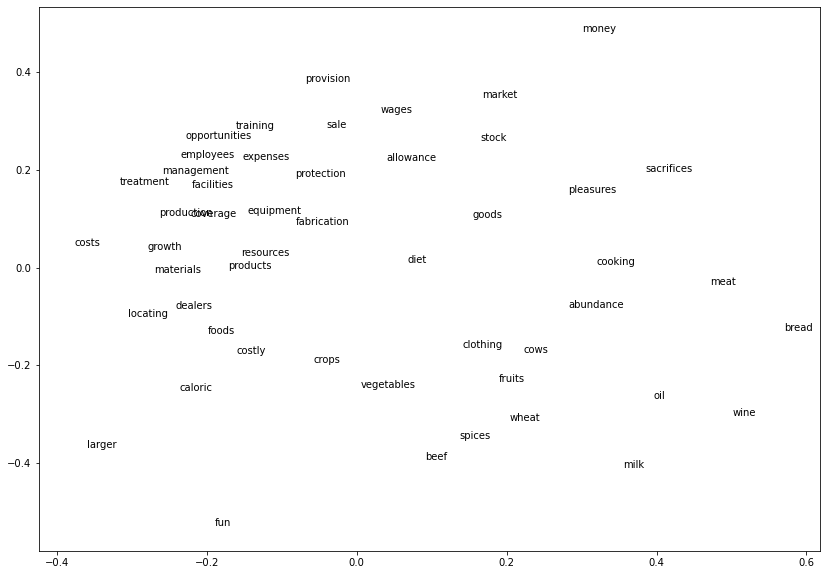

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline


_, ax = plt.subplots(figsize=(14,10))
ax.scatter(embeddings[:,0], embeddings[:,1], alpha=0)
for i in range(len(vectors)):
    ax.annotate(f_tokens[i], ((embeddings[i,0], embeddings[i,1])))

In [ ]:
import numpy as np

np.array(cleaned[0]).shape

In [ ]:
w2v_model.wv[cleaned[0]].shape

In [ ]:
w2v_model.wv[cleaned[0]].shape

In [ ]:
w2v_model.wv[cleaned[0]].shape

In [ ]:
w2v_model.wv[cleaned[0]].shape

In [ ]:
w2v_model.wv[cleaned[0]].shape

In [35]:
w2v_model.wv[cleaned[0]].shape

(40,)

In [37]:
w2v_model.wv[cleaned[0]].shape

(40, 300)